## Notebook to analyze if we see a citation increase over time, and now we might model it

In [1]:
import pandas as pd
import json
import sys
sys.path.append("../src")
from process import *
from fitting_util import *
from plotting import *

In [2]:
# how far out we should try to fit the data
# the lower the year, the greater the baseline to fit
earliest_year = 1900 # 2010 

In [3]:
# load data
import statistics as stat
# used make_citation_dataset.py to get this data
fname = "../data/doc_citations.json"
#fname = "../data/astro_only_doc_citation_bibcode_cnts_2010.json"
with open (fname, 'r') as f:
    raw_data = json.load(f)

In [4]:
#len(raw_data.keys()), sorted(raw_data.keys())

In [5]:
proc_data = {}
for year in raw_data.keys():
    yr = int(year)
    if yr >= earliest_year:
        proc_data[yr] = raw_data[year]

In [6]:
from bootstrap_stat import bootstrap_stat as bp
# look at scatter in citations for older journals to try to understand errors.
# looks like a powerlaw distribution. Use bootstrap error estimation.

def statistic(df):
    # this is mean
    if isinstance(df, list):
        return stat.mean(df) # stat.median(df)
    else:
        return stat.mean(list(df['data'])) # stat.median(list(df['data']))


y_err_all = {}
for year in proc_data.keys():
    
    df = pd.DataFrame({'data': proc_data[year]})
    dist = bp.EmpiricalDistribution(df)
    #print (dist)  
    #print(statistic(df))
    y_err_all[year] = bp.standard_error(dist, statistic, robustness=0.99)
    
    # leads to huge variance
    #y_err_all[year] = stat.pvariance(raw_data[year])
  

In [7]:
print (y_err_all)

{2011: 1.2493189136229021, 2001: 1.5932750450914568, 2006: 1.4866717845035806, 2010: 1.0194666649777018, 2000: 1.7768316650850489, 2005: 1.5511659543539866, 2007: 1.4398296463117004, 2004: 1.3723373832674173, 2017: 0.34944561890454656, 2016: 0.9638389347329809, 2013: 0.9621128881588327, 2012: 0.7005071412003282, 2019: 0.22490377032167513, 2015: 0.47905259483881013, 2014: 0.9098822037308313, 1999: 2.269348198884591, 2003: 2.738863094509163, 1998: 3.2967933027506433, 2018: 0.44650937742656643, 2002: 1.0870053770080126, 2008: 0.9368595579300657, 2009: 1.2294422095950444}


In [8]:
# if we cannot get an error, drop the point
use_year = []
y_errs = {}
for yr in y_err_all.keys():
    if y_err_all[yr] > 0.:
        use_year.append(yr)
        y_errs[yr] = y_err_all[yr]
#use_year

In [9]:
data = {}
# counts = {}
for yr in sorted(use_year):
    iyr = int(yr)
    data[iyr] = statistic(proc_data[yr])
    # counts[iyr] = stat.sqrt(len(raw_data[yr]))

x = [2021-k for k, v in sorted(data.items(), key=lambda item: item[0], reverse=False)]
y = [v for k, v in sorted(data.items(), key=lambda item: item[0], reverse=False)]
y_err = [v for k, v in sorted(y_errs.items(), key=lambda item: item[0], reverse=False)]

(array([5.47903515, 3.49273854]),
 array([1.53416281, 0.21935811]),
 51.2743376358011)

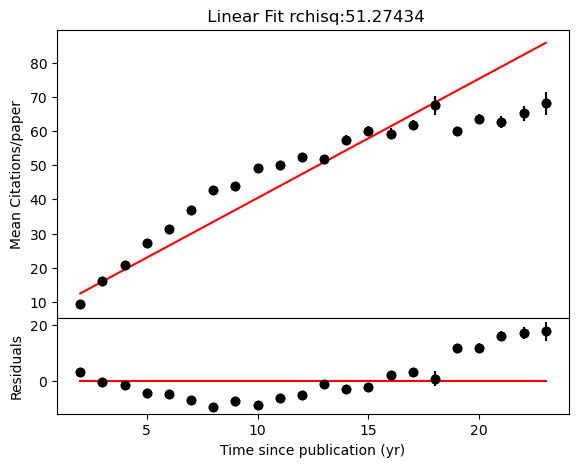

In [10]:
# Linear Fit
linefit = lambda p, x : np.array([(p[1] * dx) + p[0] for dx in x])
pfit, perr, redchisq = fit_leastsq([0.,2.], np.array(x), np.array(y), linefit, np.array(y_err))
plotdata_and_residuals (plt, f'Linear Fit rchisq:%8.5f' % redchisq, x, y, y_err, pfit, redchisq, linefit,
                       ylabel="Mean Citations/paper", xlabel='Time since publication (yr)')
pfit, perr, redchisq

(array([88.48482175,  9.97028548]),
 array([6.3895954 , 1.05115729]),
 10.923137320634051)

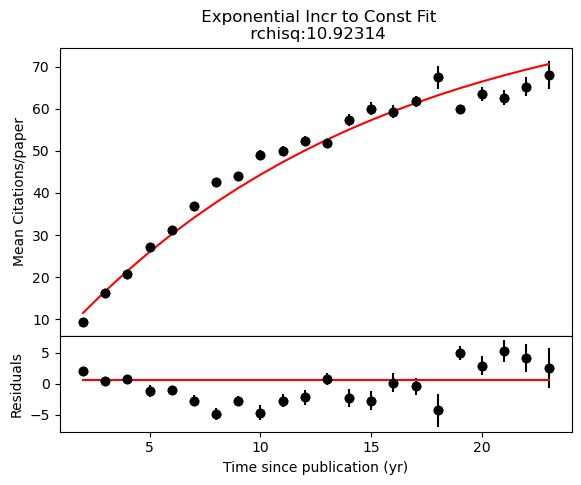

In [11]:
# Exponentially increase to constant Fit
exp_fit = lambda p, x : np.array([p[0] * (1. - (0.5) ** (dx/p[1])) for dx in x])
pfit, perr, redchisq = fit_leastsq([35.,5.6], np.array(x), np.array(y), exp_fit, np.array(y_err))
ax = plotdata_and_residuals (plt, f'Exponential Incr to Const Fit\n rchisq:%8.5f' % redchisq, 
                             x, y, y_err, pfit, redchisq, exp_fit,
                            ylabel="Mean Citations/paper", xlabel='Time since publication (yr)')
pfit, perr, redchisq

(array([59.64007361, 10.02418491, -0.39392361]),
 array([1.41623836, 0.85857232, 0.02174793]),
 8.039213407709758)

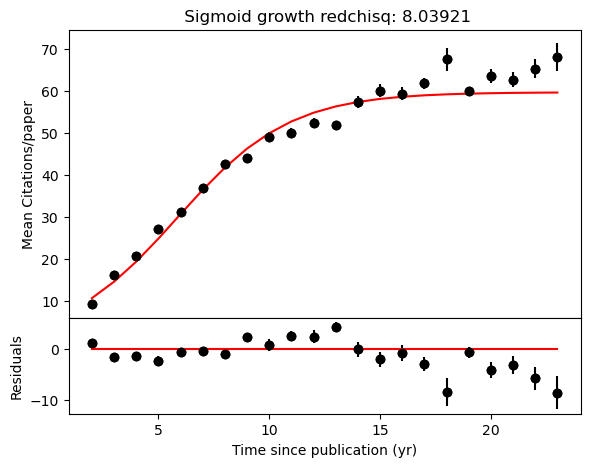

In [12]:
# Logistic (sigmoid) growth fit
import math
#sig_fit = lambda p, x : np.array([(p[0] / (1 + (p[1] * math.exp(p[2] * dx)))) for dx in x])
#sig_fit = lambda p, x : np.array([(p[0] / (1 + math.exp(p[1] * dx))) for dx in x])
#sig_fit = lambda p, x : np.array([((p[0] / (1 + (p[1] * math.exp(p[2] * dx)))) + p[3]) for dx in x])
sig_fit = lambda p, x : np.array([(p[0] / (1 + p[1]*math.exp(dx * p[2]))) for dx in x])

pfit, perr, redchisq = fit_leastsq([70., 10., -0.1], np.array(x), np.array(y), sig_fit, np.array(y_err))
ax = plotdata_and_residuals (plt, f'Sigmoid growth redchisq:%8.5f' % redchisq, 
                             x, y, y_err, pfit, redchisq, sig_fit,
                            ylabel="Mean Citations/paper", xlabel='Time since publication (yr)')
pfit, perr, redchisq

(array([138.91568103,  -0.18415645, -72.68044851]),
 array([2.07701043, 0.00658839, 1.17858621]),
 1.9747331552298961)

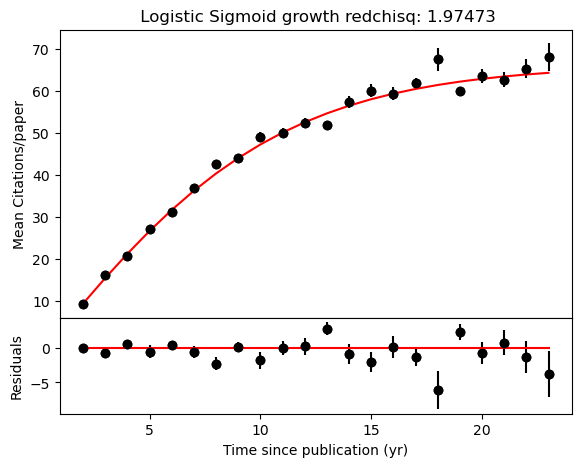

In [13]:
# Logistic (sigmoid) growth fit
import math
sig_fit = lambda p, x : np.array([((p[0] / (1 + math.exp(dx * p[1]))) + p[2]) for dx in x])

#pfit, perr, redchisq = fit_leastsq([70., 10., -0.1, 0.], np.array(x), np.array(y), sig_fit, np.array(y_err))
pfit, perr, redchisq = fit_leastsq([70., -0.1, 0.], np.array(x), np.array(y), sig_fit, np.array(y_err))
ax = plotdata_and_residuals (plt, f'Logistic Sigmoid growth redchisq:%8.5f' % redchisq, 
                             x, y, y_err, pfit, redchisq, sig_fit,
                            ylabel="Mean Citations/paper", xlabel='Time since publication (yr)')
pfit, perr, redchisq

(array([18.62983379]), array([0.61399946]), 45.042759853171944)

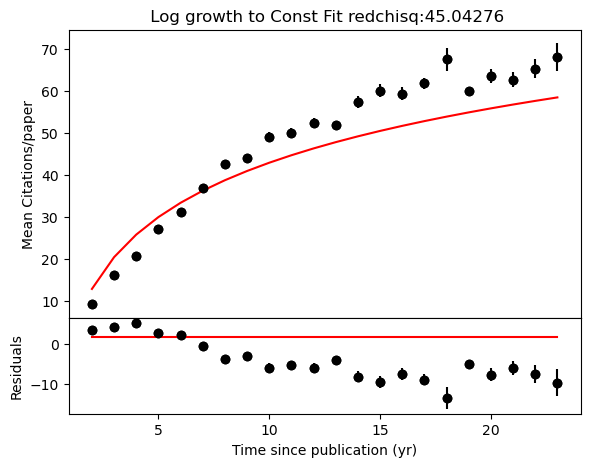

In [14]:
# Logarithmic growth fit
import math
log_fit = lambda p, x : np.array([(p[0] * math.log(dx)) for dx in x])

pfit, perr, redchisq = fit_leastsq([1.], np.array(x), np.array(y), log_fit, np.array(y_err))
ax = plotdata_and_residuals (plt, f'Log growth to Const Fit redchisq:%8.5f' % redchisq, 
                             x, y, y_err, pfit, redchisq, log_fit,
                            ylabel="Mean Citations/paper", xlabel='Time since publication (yr)')
pfit, perr, redchisq